In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import revsic_multispeakerglowtts as glowtts
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [5]:
speaker_model = malaya_speech.speaker_vector.deep_model('vggvox-v2')

In [6]:
wav['wav'].shape

(1, 104448)

In [7]:
audio_16k = malaya_speech.resample(wav['wav'][0], 22050, 16000)
v = speaker_model([audio_16k])
v.shape

(1, 512)

In [8]:
i = tf.placeholder(tf.int32, [None, None])
i_lengths = tf.placeholder(tf.int32, [None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
speakers = tf.placeholder(tf.float32, [None, 512])

In [9]:
config = glowtts.Config(mel = 80, vocabs = 66, gin_channels = 512)

In [10]:
model = glowtts.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
loss, losses, attn = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths,
                                       g = speakers)
loss, losses, attn

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [12]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths, g = speakers)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'model/mul_90:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [13]:
parameters = {
    'optimizer_params': {'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-9},
    'lr_policy_params': {
        'warmup_steps': 40000,
    },
}

def noam_schedule(step, learning_rate, channels, warmup_steps=4000):
    return learning_rate * channels ** -0.5 * \
            tf.minimum(step ** -0.5, step * warmup_steps ** -1.5)

def learning_rate_scheduler(global_step):
    return transformer_schedule(
        tf.cast(global_step, tf.float32),
        config.channels,
        **parameters['lr_policy_params'],
    )

In [14]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9).minimize(loss)

In [15]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [18]:
v_ = np.concatenate([v, v])
v_.shape

(2, 512)

In [20]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408],
                                               speakers: v_})

CPU times: user 870 ms, sys: 215 ms, total: 1.09 s
Wall time: 225 ms


In [21]:
for k in range(200):
    o = sess.run([loss, losses, optimizer], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408],
                                               speakers: v_})
    print(k, o)

0 [1.074271, {'nll': 0.7970535, 'durloss': 0.2772174}, None]
1 [0.83979344, {'nll': 0.66087186, 'durloss': 0.17892161}, None]
2 [0.7599812, {'nll': 0.59940094, 'durloss': 0.16058029}, None]
3 [0.74425936, {'nll': 0.55357563, 'durloss': 0.19068372}, None]
4 [0.6944375, {'nll': 0.5093507, 'durloss': 0.18508677}, None]
5 [0.67187536, {'nll': 0.46573398, 'durloss': 0.20614138}, None]
6 [0.70596254, {'nll': 0.42426923, 'durloss': 0.2816933}, None]
7 [0.6441797, {'nll': 0.3854595, 'durloss': 0.25872016}, None]
8 [0.76156366, {'nll': 0.3485399, 'durloss': 0.41302377}, None]
9 [0.7059109, {'nll': 0.31283337, 'durloss': 0.39307755}, None]
10 [0.5785157, {'nll': 0.27733234, 'durloss': 0.30118337}, None]
11 [0.4988556, {'nll': 0.24115264, 'durloss': 0.25770295}, None]
12 [0.48733866, {'nll': 0.20373732, 'durloss': 0.28360134}, None]
13 [0.5027126, {'nll': 0.16512835, 'durloss': 0.33758423}, None]
14 [0.45143723, {'nll': 0.12538143, 'durloss': 0.32605582}, None]
15 [0.3583521, {'nll': 0.08414944, 

124 [-1.1426055, {'nll': -1.1691126, 'durloss': 0.026507013}, None]
125 [-1.1624092, {'nll': -1.170277, 'durloss': 0.00786776}, None]
126 [-1.1608373, {'nll': -1.179018, 'durloss': 0.018180711}, None]
127 [-1.179971, {'nll': -1.1906549, 'durloss': 0.010683918}, None]
128 [-1.1881288, {'nll': -1.1953275, 'durloss': 0.007198702}, None]
129 [-1.1987662, {'nll': -1.205138, 'durloss': 0.006371721}, None]
130 [-1.2063403, {'nll': -1.210932, 'durloss': 0.0045916485}, None]
131 [-1.2119085, {'nll': -1.2208841, 'durloss': 0.0089756325}, None]
132 [-1.2206169, {'nll': -1.2270267, 'durloss': 0.0064097135}, None]
133 [-1.2279757, {'nll': -1.2335775, 'durloss': 0.0056018047}, None]
134 [-1.2297456, {'nll': -1.2386072, 'durloss': 0.0088616}, None]
135 [-1.2216101, {'nll': -1.2341354, 'durloss': 0.012525357}, None]
136 [-1.2157159, {'nll': -1.2305193, 'durloss': 0.01480342}, None]
137 [-1.243334, {'nll': -1.2511158, 'durloss': 0.0077817277}, None]
138 [-1.2490535, {'nll': -1.2638154, 'durloss': 0.014

In [22]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408],
                                               speakers: v_})

CPU times: user 854 ms, sys: 203 ms, total: 1.06 s
Wall time: 225 ms


In [23]:
o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                        mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408],
                                                  speakers: v_})

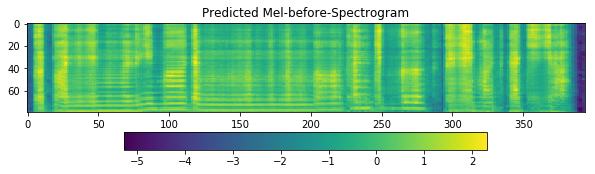

In [24]:
mel_outputs_ = np.reshape(o[0][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

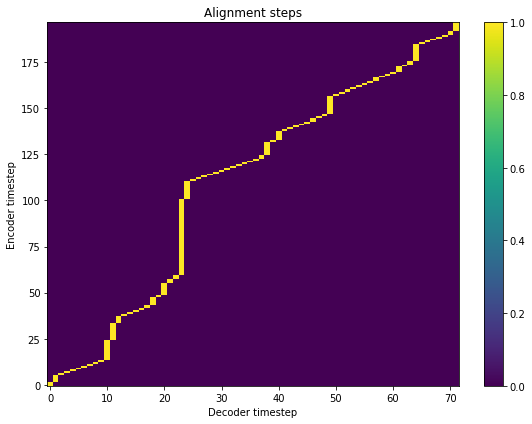

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [26]:
saver = tf.train.Saver()
saver.save(sess, 'test/model.ckpt')

'test/model.ckpt'

In [27]:
!ls -lh test

total 1009896
-rw-r--r--  1 huseinzolkepli  staff    77B Oct 14 13:29 checkpoint
-rw-r--r--  1 huseinzolkepli  staff   453M Oct 14 13:29 model.ckpt.data-00000-of-00001
-rw-r--r--  1 huseinzolkepli  staff    89K Oct 14 13:29 model.ckpt.index
-rw-r--r--  1 huseinzolkepli  staff    32M Oct 14 13:29 model.ckpt.meta
